# FunUQ for MD
## Sam Reeve and Alejandro Strachan
### Replication of: Reeve, S. T. & Strachan, A. Error correction in multi-fidelity molecular dynamics simulations using functional uncertainty quantification. J. Comput. Phys. 334, 207–220 (2017). __[(DOI: 10.1016/j.jcp.2016.12.039)](https://doi.org/10.1016/j.jcp.2016.12.039)__

### Lennard-Jones / Sine modified Lennard-Jones at 1300K and 1 atm (Pre-run simulations)
#### This notebook goes through all steps of functional uncertainty quantification FunUQ for interatomic potential in molecular dynamics, matching one case from the published paper. The main steps are: 
 * Define folders, simulation system, and models
 * (Run simulations)
 * Calculate functional derivatives
 * Calculate correction for quantities of interest due to changing from one function to another

In [1]:
import sys, os, numpy as np
# Relative path from notebook to module
sys.path.insert(0, '../../lib/')
sys.path.insert(0, '../../lib/FunUQ/')

In [2]:
# Import FunUQ module
from FunUQ import *

# Provides access to nanoHUB simulation codes (LAMMPS)
from hublib import use

# Utility functions (Austin Zadoks)
from nH_utils import *

In [3]:
% use lammps-09Dec14
% matplotlib notebook

In [4]:
# "True" will run new simulations below
# Change after first usage to only analyze results
run_main = False
run_verify = False
run_perturb = False
run_bruteforce = False

## System setup: define quantities of interest and interatomic potentials 

In [5]:
rundir = os.getcwd()
startdir = os.path.abspath(os.path.join(rundir, 'init/'))

mainname = 'main'
correctname = 'lj_sine'

In [6]:
QoI_list = ['PotEng', 'Press']
Nqoi = len(QoI_list)
QoI_dict = {'description': 'Replication of Reeve and Strachan, J Comp Phys (2017)',
            'Ncopies': 2,
            'units': ['eV/atom', 'GPa'],
            #'overwrite': True, 
           }

In [7]:
Pot_main = Potential('lj', paramdir=startdir, create=True, N=7000, rmax=7.0, cut=5.787)
Pot_correct = Potential('lj_sine', paramdir=startdir, potfile='lj_sine.table', create=False, N=7000, rmax=7.0, cut=5.787)

In [8]:
QoI = QuantitiesOfInterest(QoI_list, Pot_main,
                           startdir, rundir, mainname, 'metal',
                           input_dict=QoI_dict)
QoI_correct = QuantitiesOfInterest(QoI_list, Pot_correct,
                                   startdir, rundir, correctname, 'metal',
                                   input_dict=QoI_dict)

<IPython.core.display.Javascript object>


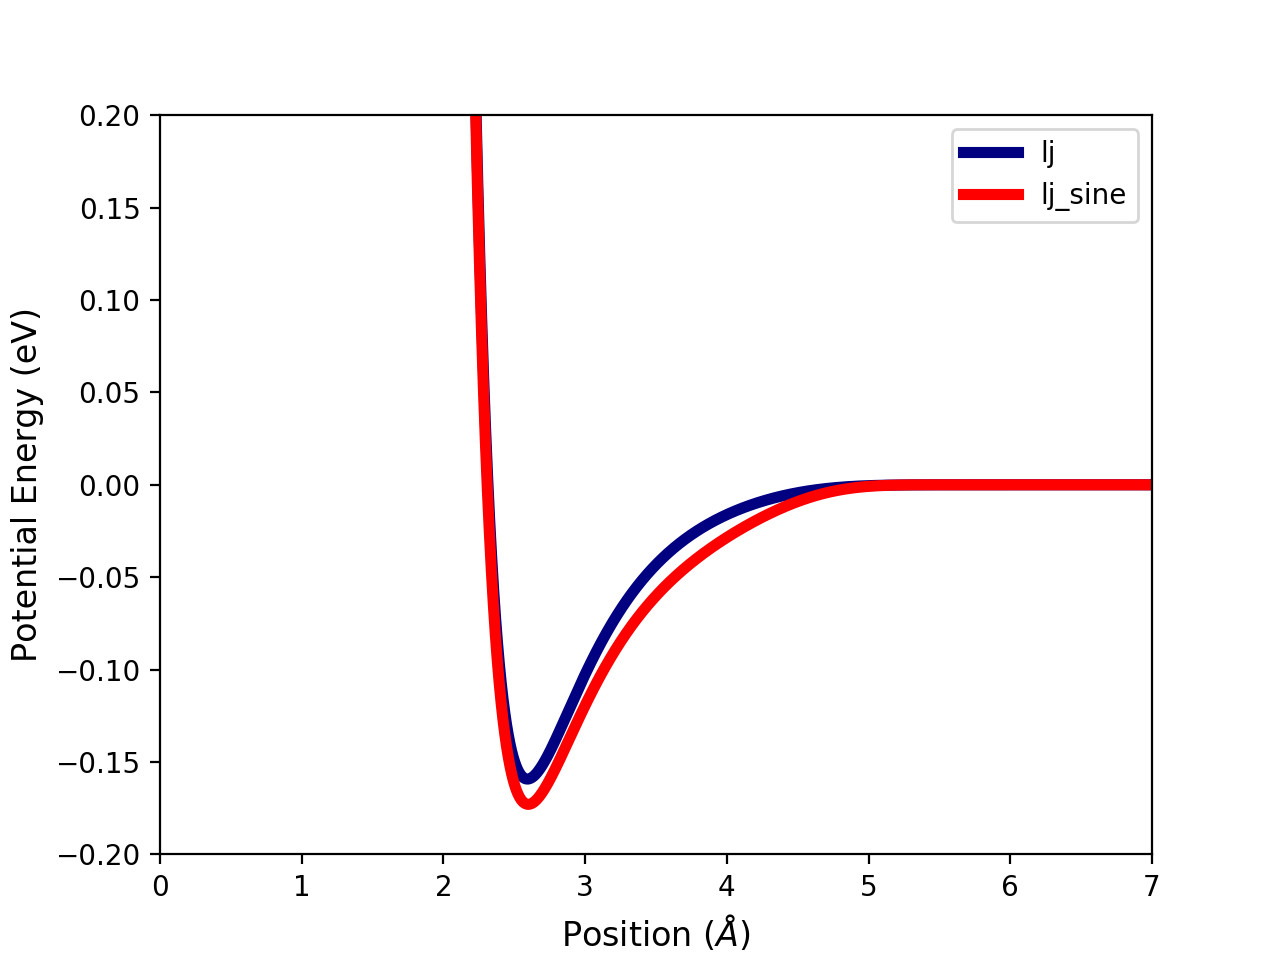

In [9]:
ax1 = Pot_main.plot()
ax1 = Pot_correct.plot(ax=ax1, color='red', unit=QoI.PE_units)

#### Compare the plot above to Reeve & Strachan 2017, Figure 1 (Sine 1)

## Run simulations or extract results

In [10]:
if run_main:
    QoI.run_lammps(mode='nanoHUB_submit') # 'nanoHUB_local'
if run_verify:
    QoI_correct.run_lammps(mode='nanoHUB_submit')

In [11]:
#submit_status()
local_status(rundir, [mainname, correctname])

The following may not be accurate with remote running jobs
This counts only jobs which have started/finished with files copied

Status for main
   * 2 Folders with running/unfinished runs
Status for lj_sine
   * 2 Folders with running/unfinished runs


In [12]:
QoI.extract_lammps()
QoI_correct.extract_lammps()
print(QoI); print(QoI_correct)

PotEng	Press
-0.704	0.122	

PotEng	Press
-0.850	-1.129	



## Calculate functional derivatives

In [13]:
FD_dict = {'alist': [-1e-8, -2e-8, 1e-8, 2e-8],
          }

In [14]:
FuncDer = FuncDer_perturb_coord(QoI, Pot_main,
                                 input_dict=FD_dict)

In [15]:
if run_bruteforce and FuncDer.method == 'bruteforce':
    FuncDer.run_lammps()
elif run_perturb and FuncDer.method == 'perturbative_allatom':
    FuncDer.rerun_gauss()

In [16]:
FuncDer.prepare_FD()
FuncDer.calc_FD()

Calculated perturbations
Extracted RDF data for copy 0
Extracted RDF data for copy 1
Calculated perturbation Hamiltonian contributions
Calculated exponential weights
Calculated functional derivatives



<IPython.core.display.Javascript object>


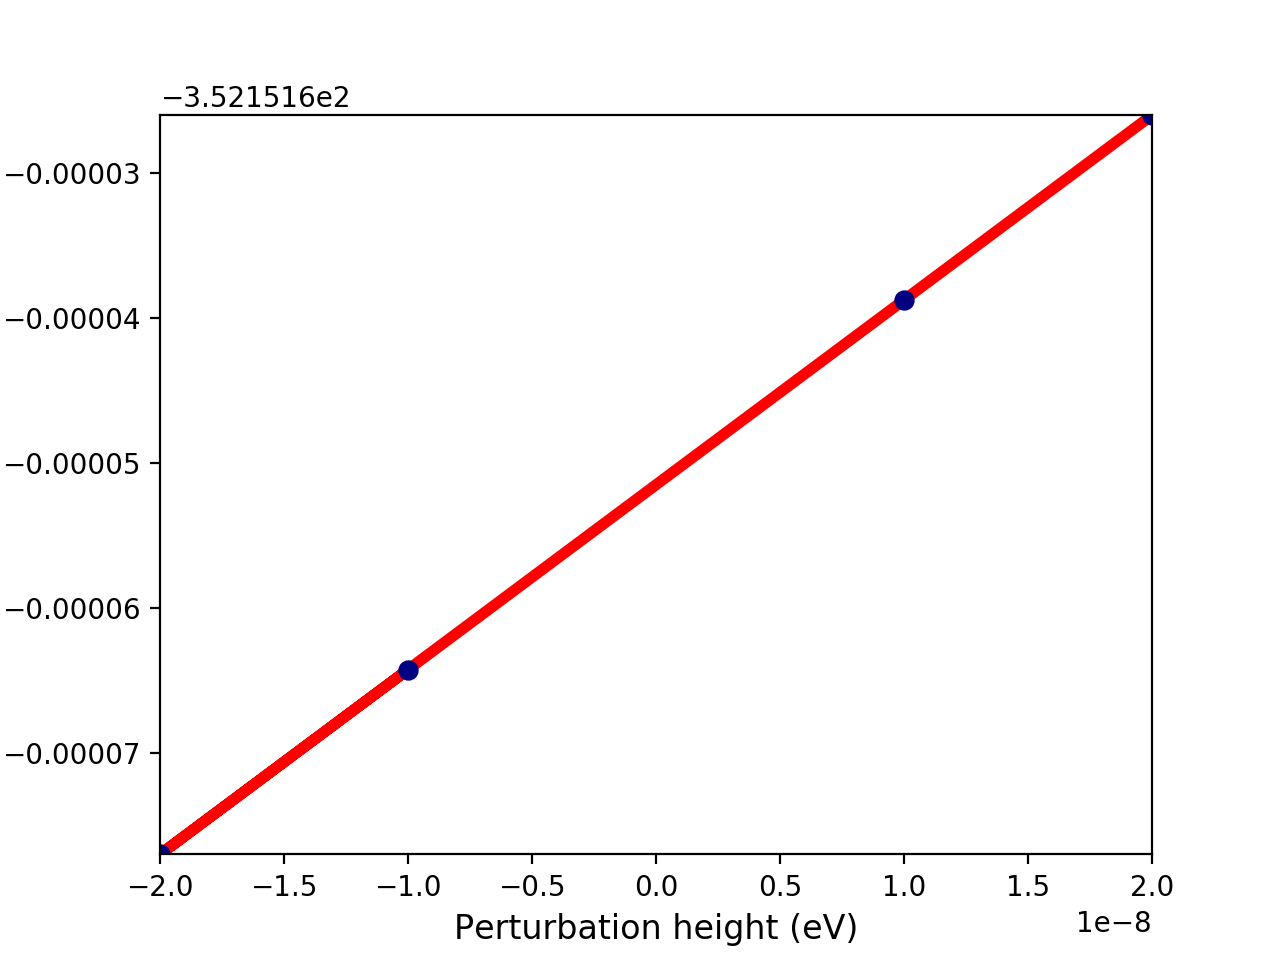

In [17]:
FuncDer.plot_perturb(0)

#### Compare the plot above to Reeve & Strachan 2018, Figure 2b
#### (Figure 2a in that paper exagerates the size of the perturbations, not visible if plotted here)

<IPython.core.display.Javascript object>


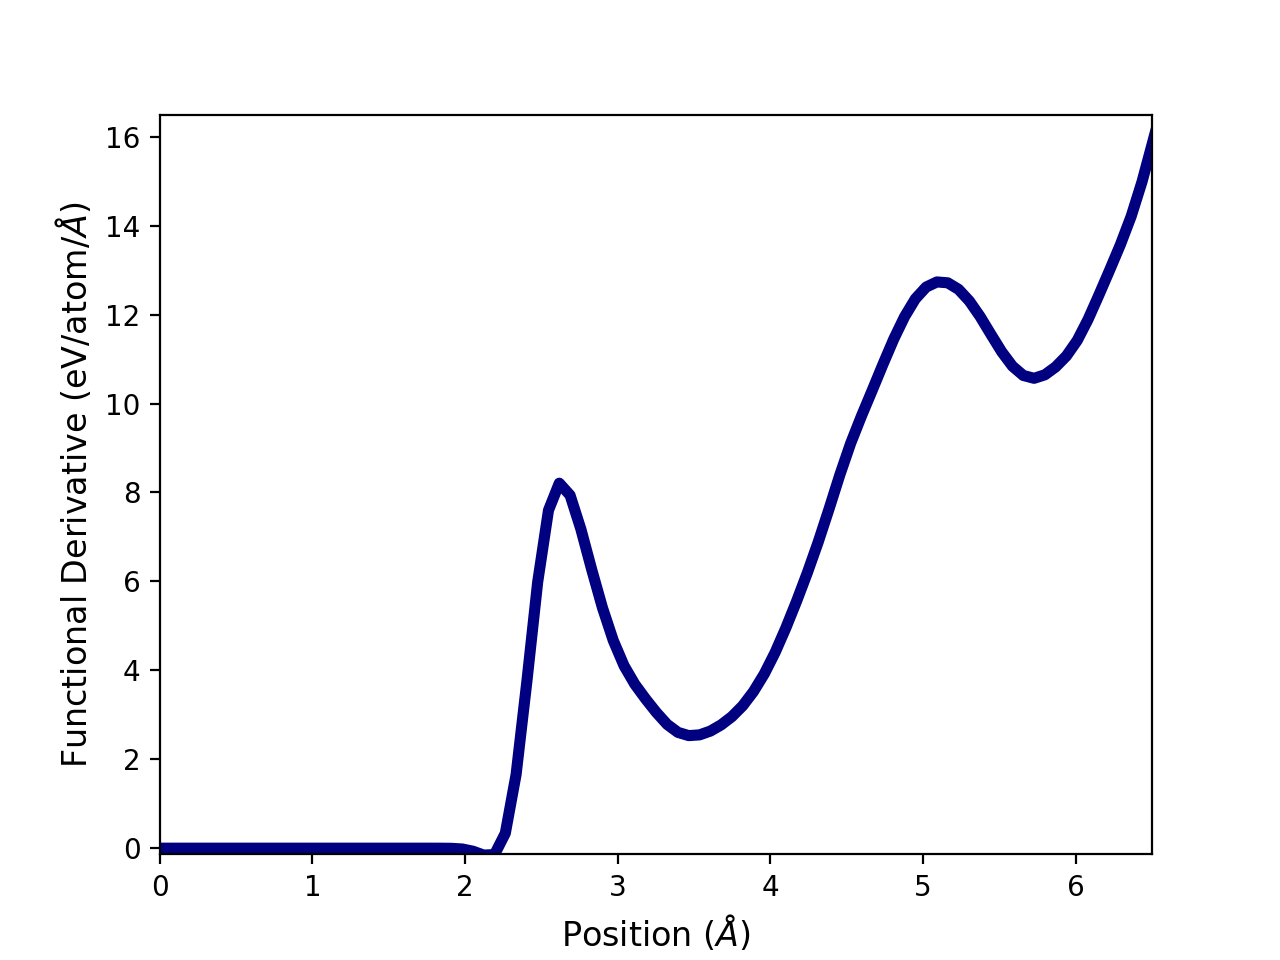

<IPython.core.display.Javascript object>


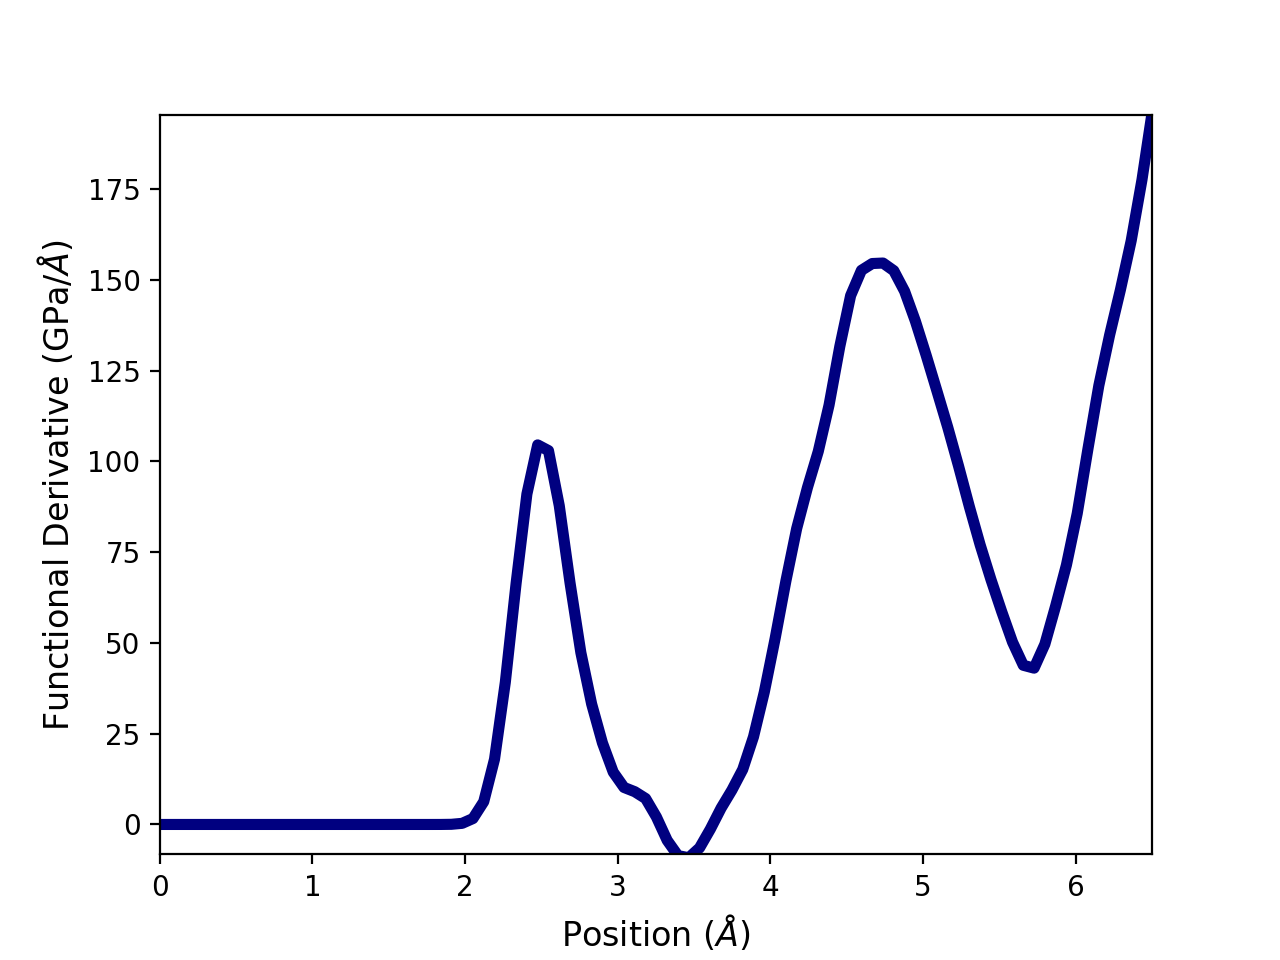

In [18]:
for x in range(Nqoi):
    FuncDer.write_FD(x)
    FuncDer.plot_FD(x)

#### Compare the plot for potential energy to Reeve & Strachan 2017, Figure 4a

## Correct quantities of interest

In [19]:
Correct = FunUQ(Pot_main, Pot_correct, QoI.Q_names, QoI.Qavg, QoI_correct.Qavg, PE_units=QoI.PE_units,
                Q_units=QoI.units, FD=FuncDer.funcder, R=FuncDer.rlist)

Calculated discrepancy



<IPython.core.display.Javascript object>


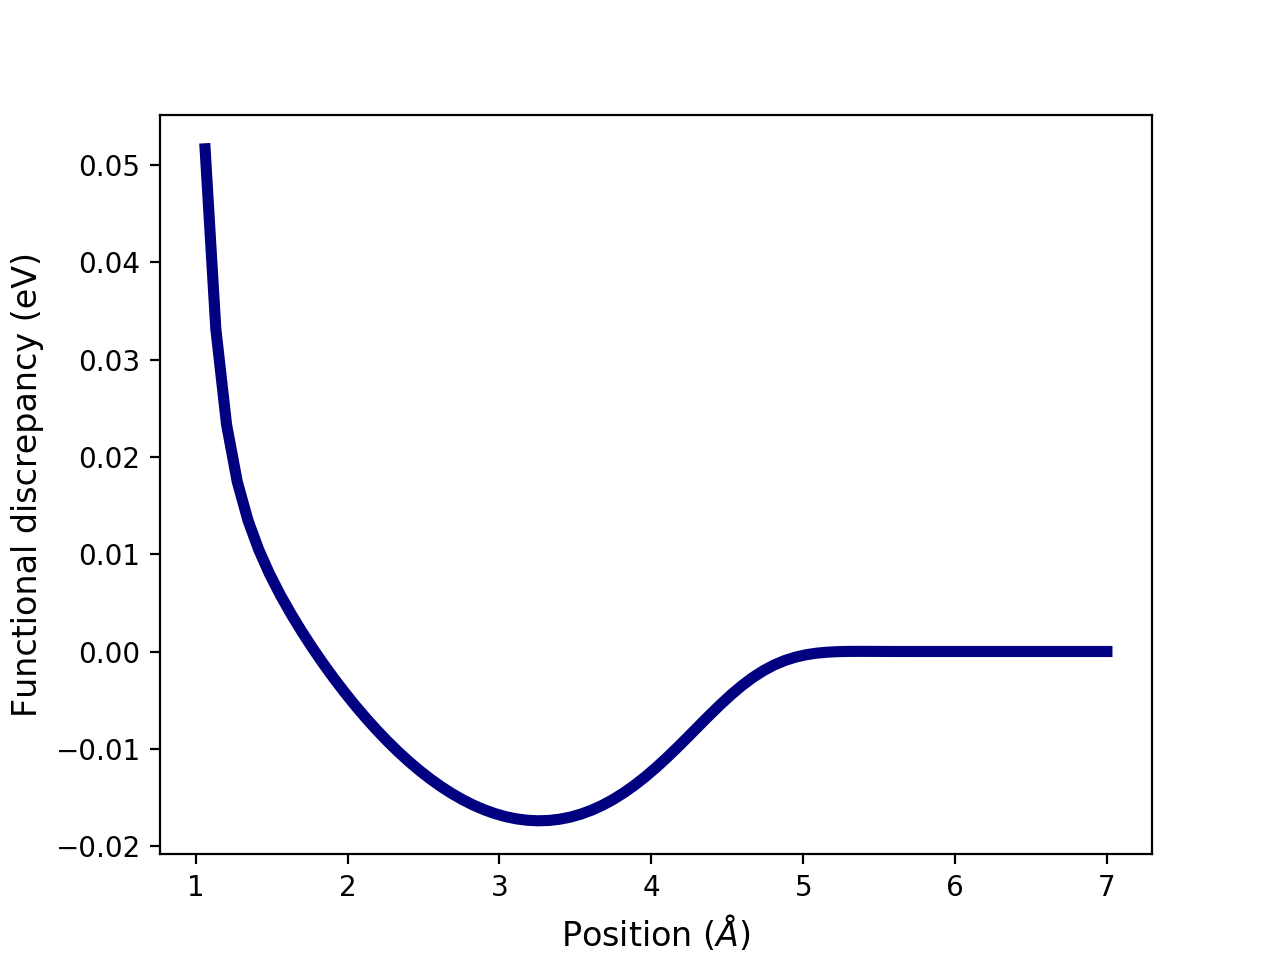

In [20]:
Correct.discrepancy()
Correct.plot_discrep()

#### Compare the plot above to Reeve & Strachan 2017, Figure 4b

In [21]:
Correct.correct()

Calculated correction terms
***** PotEng *****
FunUQ		 FunUQ		 Direct		 Main		 Correction
% error		 correction	 simulation	 QoI		 QoI
-0.05%		 -1.461e-01	 -1.457e-01	 -7.043e-01	 -8.500e-01

***** Press *****
FunUQ		 FunUQ		 Direct		 Main		 Correction
% error		 correction	 simulation	 QoI		 QoI
-0.48%		 -1.257e+00	 -1.251e+00	 1.223e-01	 -1.129e+00



#### Compare the values above to Reeve & Strachan 2017, Table B.1-2 (Sine 1)

<IPython.core.display.Javascript object>


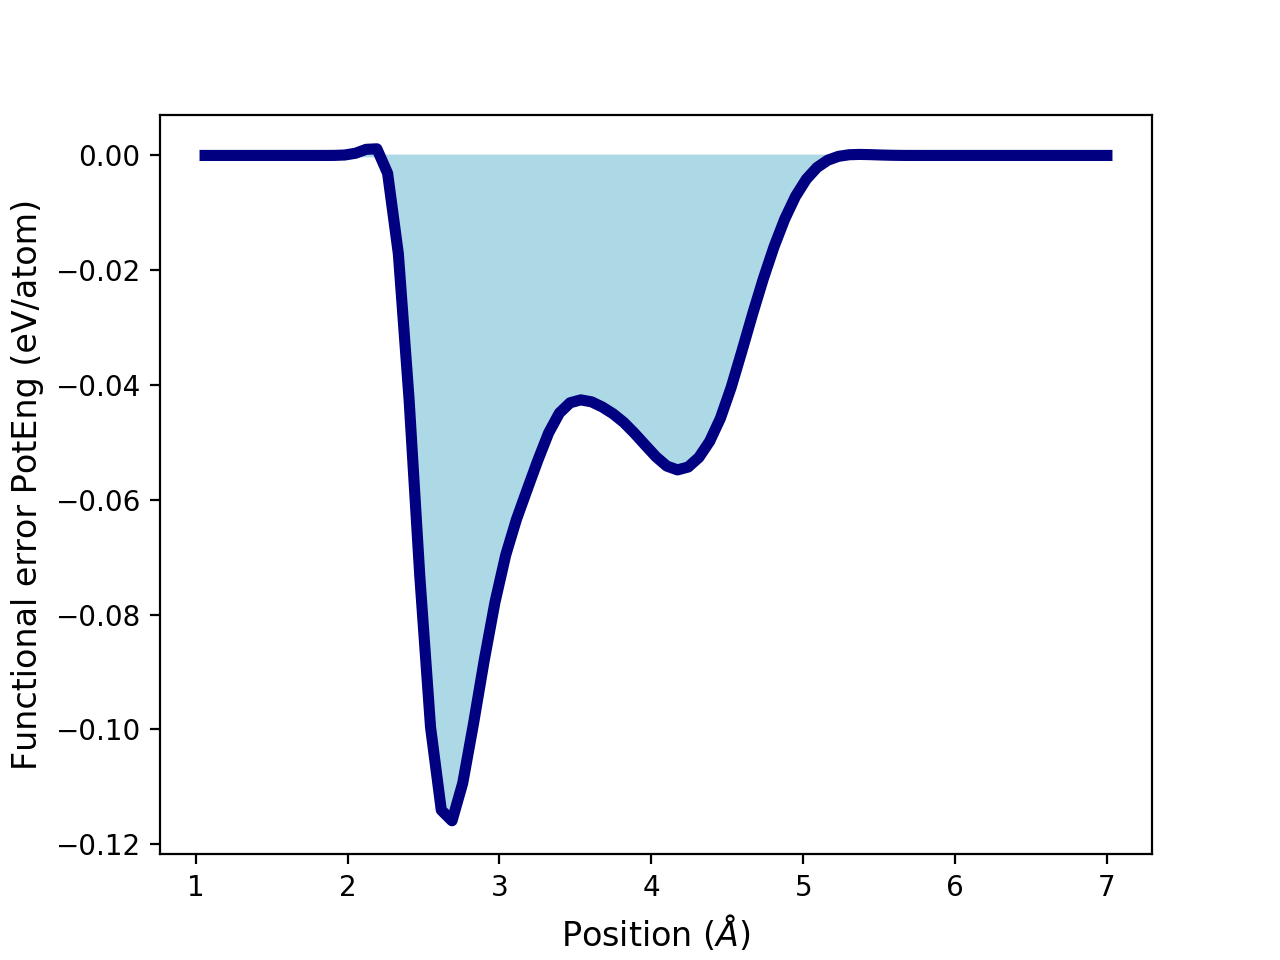

<IPython.core.display.Javascript object>


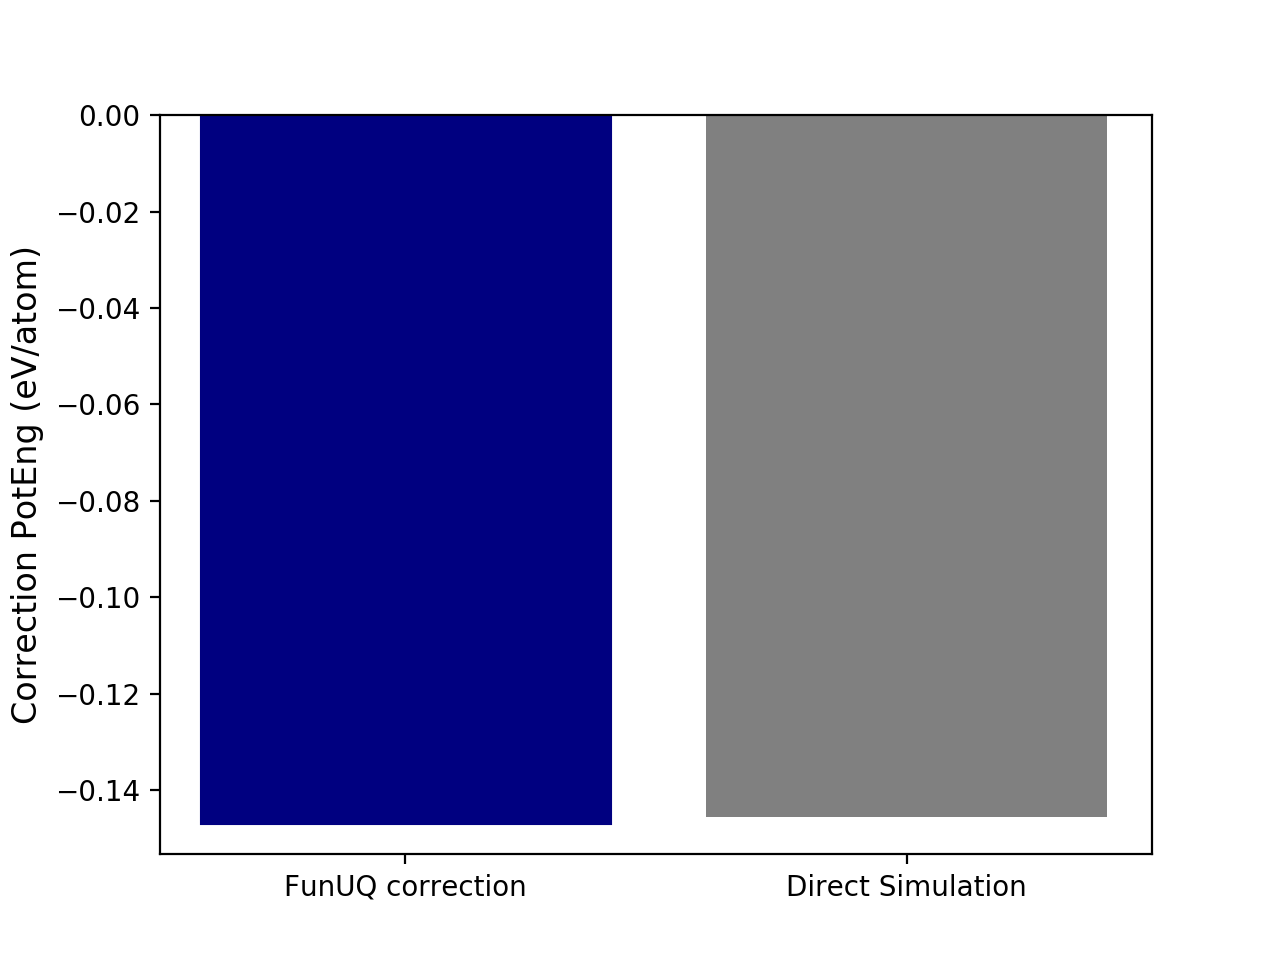

<IPython.core.display.Javascript object>


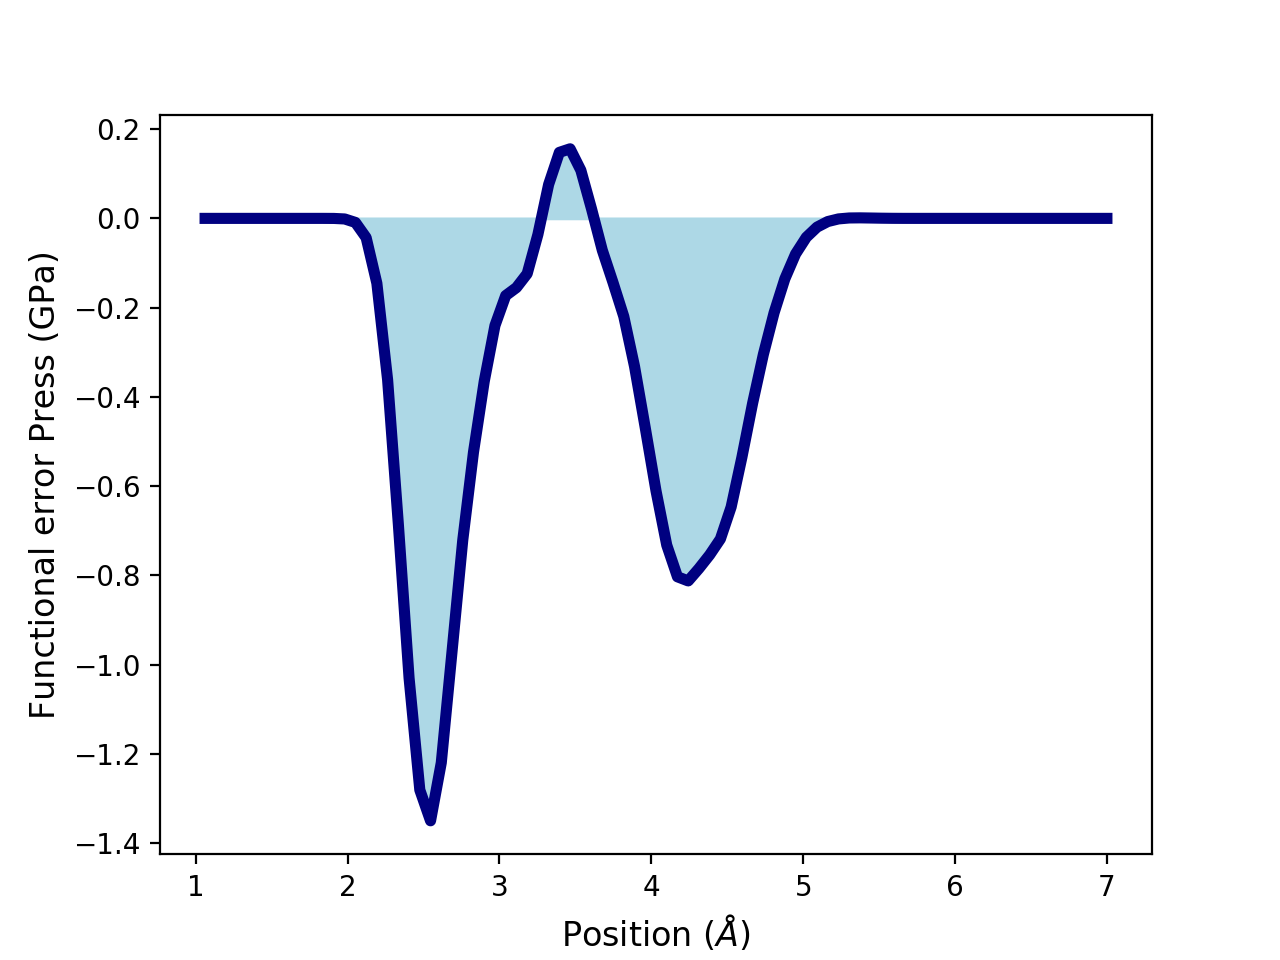

<IPython.core.display.Javascript object>


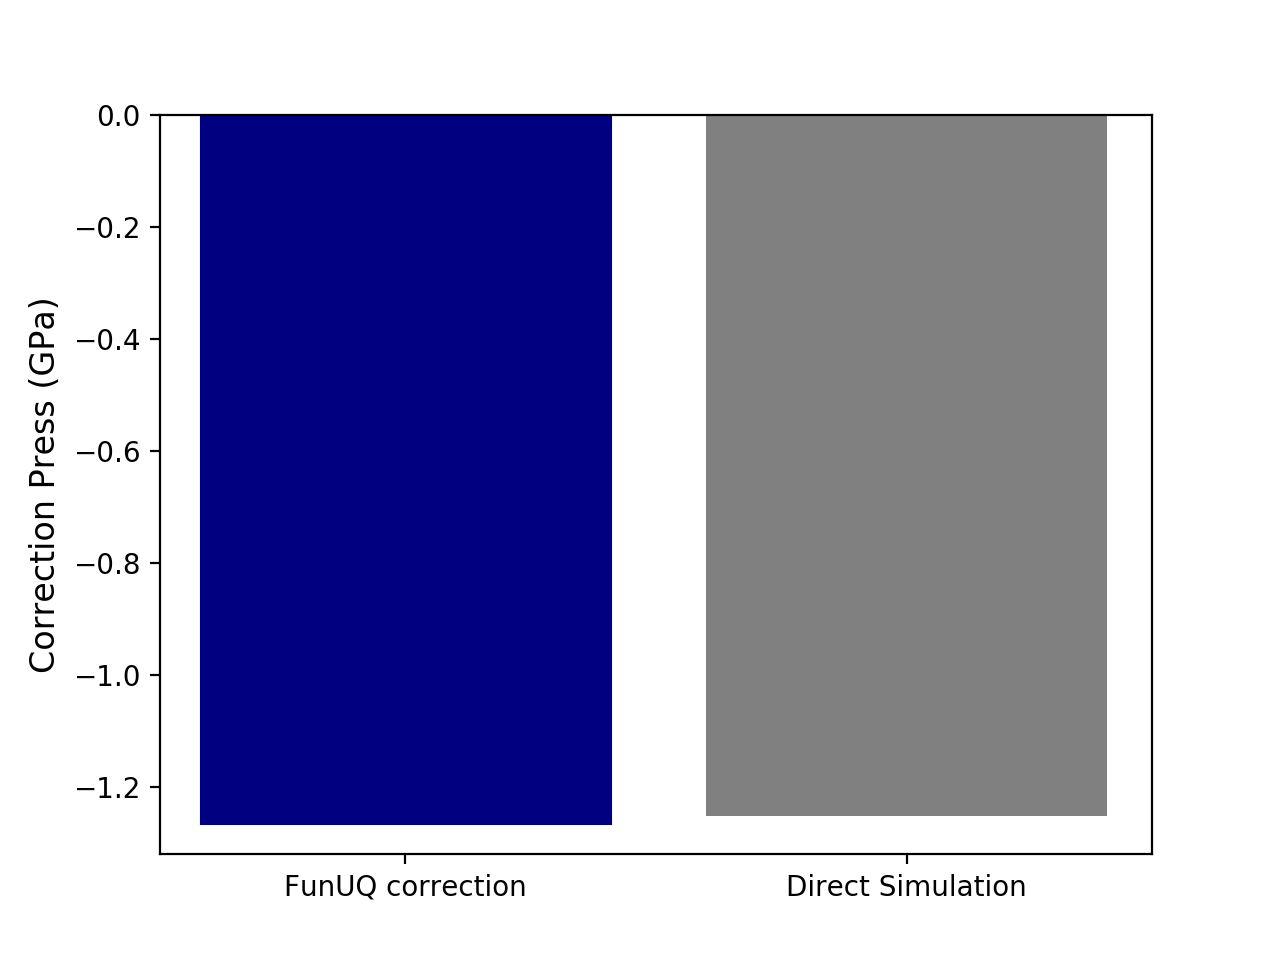

In [22]:
for x in range(Nqoi):
    Correct.plot_funcerr(x)
    Correct.plot_correction(x)

#### Compare the plot for potential energy to Reeve & Strachan 2017, Figure 4c
#### Compare the bar charts to Reeve & Strachan 2017, Figure 5 (Sine 1)